# 데이터들을 factor로 변경

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../data/create_datasets.ipynb) in the [data](../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

In [5]:
START = 2000
END = 2018

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['finance_datareader/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['kospi/stocks'].loc[:, ['시가총액', '상장일', 'sector']]

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4690 entries, 2000-01-04 to 2018-12-28
Columns: 765 entries, 000020 to 298690
dtypes: float64(765)
memory usage: 27.4 MB


In [8]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 770 entries, 095570 to 003280
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가총액    770 non-null    float64
 1   상장일     770 non-null    float64
 2   sector  770 non-null    object 
dtypes: float64(2), object(1)
memory usage: 24.1+ KB


### 회사정보 데이터 유지

`stocks` 겹치는 부분 제거와 인덱스 이름 설정

In [9]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

가격 데이터와 회사 정보 데이터의 겹치는 ticker만 출력

In [10]:
shared = prices.columns.intersection(stocks.index)

In [11]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 000020 to 298690
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가총액    720 non-null    float64
 1   상장일     720 non-null    float64
 2   sector  720 non-null    object 
dtypes: float64(2), object(1)
memory usage: 22.5+ KB


In [12]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4690 entries, 2000-01-04 to 2018-12-28
Columns: 720 entries, 000020 to 298690
dtypes: float64(720)
memory usage: 25.8 MB


In [13]:
assert prices.shape[1] == stocks.shape[0]

## 월별 수익률 생성

전략의 백테스트 시간을 줄이기 위해 월병 수익률을 수정주가를 이용해서 구한다:

In [14]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [15]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228 entries, 2000-01-31 to 2018-12-31
Freq: M
Columns: 720 entries, 000020 to 298690
dtypes: float64(720)
memory usage: 1.3 MB


In [16]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 122151 entries, ('000020', Timestamp('2001-01-31 00:00:00', freq='M')) to ('282330', Timestamp('2018-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   122151 non-null  float64
 1   return_2m   122151 non-null  float64
 2   return_3m   122151 non-null  float64
 3   return_6m   122151 non-null  float64
 4   return_9m   122151 non-null  float64
 5   return_12m  122151 non-null  float64
dtypes: float64(6)
memory usage: 6.1+ MB


## 데이터가 10년이 안되는 종목들 제거

In [17]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 112893 entries, ('000020', Timestamp('2001-01-31 00:00:00', freq='M')) to ('097950', Timestamp('2018-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   112893 non-null  float64
 1   return_2m   112893 non-null  float64
 2   return_3m   112893 non-null  float64
 3   return_6m   112893 non-null  float64
 4   return_9m   112893 non-null  float64
 5   return_12m  112893 non-null  float64
dtypes: float64(6)
memory usage: 5.6+ MB


In [18]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,112893.000000,112893.000000,112893.000000,112893.000000,112893.000000,112893.000000
mean,0.012874,0.008594,0.007124,0.005969,0.005586,0.005225
std,0.132635,0.092508,0.074875,0.053283,0.042913,0.037370
min,-0.314542,-0.229911,-0.188484,-0.133638,-0.109127,-0.094414
25%,-0.062104,-0.044584,-0.036308,-0.024918,-0.019623,-0.016613
50%,0.000000,0.000000,0.000678,0.001356,0.002203,0.002804
75%,0.070963,0.052451,0.044219,0.032942,0.028440,0.025642
max,0.518968,0.330760,0.256500,0.175006,0.135346,0.113848


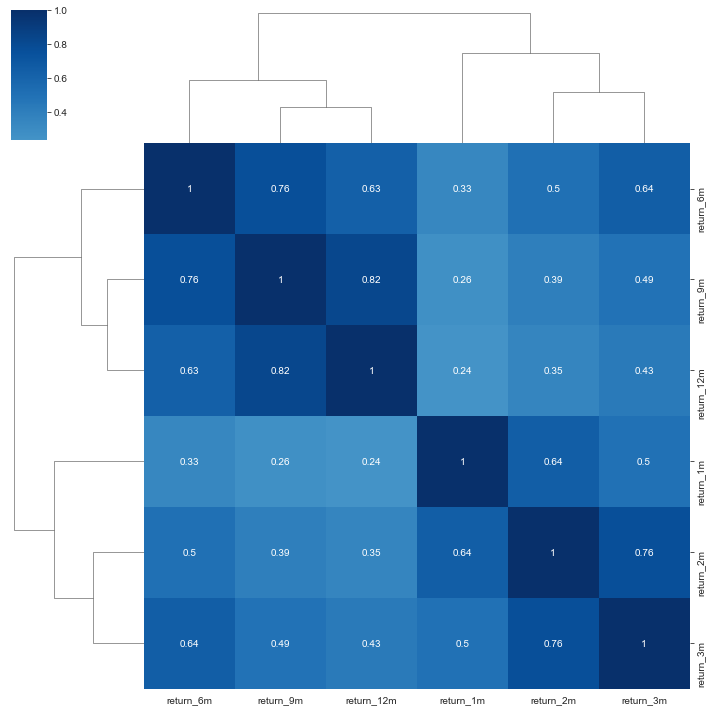

In [19]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,670 tickers.

In [20]:
data.index.get_level_values('ticker').nunique()

549

## Factor의 베타

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 9, Time Series Models](../09_time_series_models).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [21]:
factor_data = pd.read_hdf('../data/assets.h5', 'fama_french/equal_weight/korea')

In [22]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 299 entries, 1996-07-31 to 2021-05-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  299 non-null    float64
 1   SMB     299 non-null    float64
 2   HML     299 non-null    float64
 3   RMW     299 non-null    float64
 4   CMA     299 non-null    float64
dtypes: float64(5)
memory usage: 14.0 KB


In [23]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 112893 entries, ('000020', Timestamp('2001-01-31 00:00:00', freq='M')) to ('097950', Timestamp('2018-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     112893 non-null  float64
 1   SMB        112893 non-null  float64
 2   HML        112893 non-null  float64
 3   RMW        112893 non-null  float64
 4   CMA        112893 non-null  float64
 5   return_1m  112893 non-null  float64
dtypes: float64(6)
memory usage: 5.6+ MB


In [24]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [25]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,100266.000000,100266.000000,100266.000000,100266.000000,100266.000000,112893.000000
mean,1.292140,0.009539,0.012283,0.003871,0.037659,1.203882
std,0.876346,1.532640,1.178647,1.332517,1.387364,2.570500
min,-4.079304,-10.258632,-9.058126,-11.277459,-8.586641,-23.334802
25%,0.735617,-0.855327,-0.592219,-0.725778,-0.716503,0.000000
50%,1.240589,0.008079,0.073071,0.014893,0.070960,1.019776
75%,1.789727,0.863364,0.687536,0.752661,0.828503,2.637858
max,6.538036,9.177456,6.992780,8.419101,6.923653,18.709718


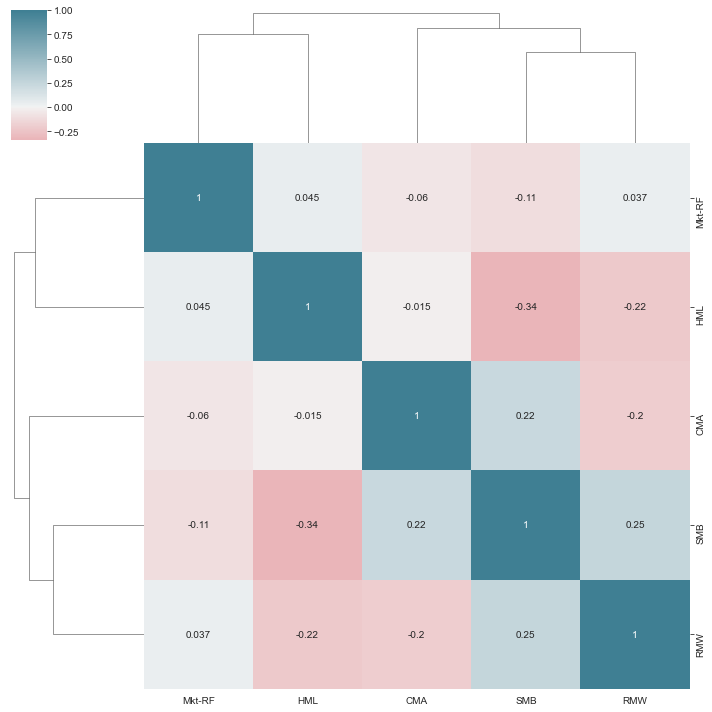

In [26]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [27]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 112893 entries, ('000020', Timestamp('2001-01-31 00:00:00', freq='M')) to ('097950', Timestamp('2018-12-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   112893 non-null  float64
 1   return_2m   112893 non-null  float64
 2   return_3m   112893 non-null  float64
 3   return_6m   112893 non-null  float64
 4   return_9m   112893 non-null  float64
 5   return_12m  112893 non-null  float64
 6   Mkt-RF      99717 non-null   float64
 7   SMB         99717 non-null   float64
 8   HML         99717 non-null   float64
 9   RMW         99717 non-null   float64
 10  CMA         99717 non-null   float64
dtypes: float64(11)
memory usage: 14.0+ MB


### 결측치 beta에 대해서 평균값 대체

In [28]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 112893 entries, ('000020', Timestamp('2001-01-31 00:00:00', freq='M')) to ('097950', Timestamp('2018-12-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   112893 non-null  float64
 1   return_2m   112893 non-null  float64
 2   return_3m   112893 non-null  float64
 3   return_6m   112893 non-null  float64
 4   return_9m   112893 non-null  float64
 5   return_12m  112893 non-null  float64
 6   Mkt-RF      112893 non-null  float64
 7   SMB         112893 non-null  float64
 8   HML         112893 non-null  float64
 9   RMW         112893 non-null  float64
 10  CMA         112893 non-null  float64
dtypes: float64(11)
memory usage: 14.0+ MB


## 모멘텀 factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [29]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [30]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [31]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 112893 entries, ('000020', Timestamp('2001-01-31 00:00:00', freq='M')) to ('097950', Timestamp('2018-12-31 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      112893 non-null  float64
 1   return_2m      112893 non-null  float64
 2   return_3m      112893 non-null  float64
 3   return_6m      112893 non-null  float64
 4   return_9m      112893 non-null  float64
 5   return_12m     112893 non-null  float64
 6   Mkt-RF         112893 non-null  float64
 7   SMB            112893 non-null  float64
 8   HML            112893 non-null  float64
 9   RMW            112893 non-null  float64
 10  CMA            112893 non-null  float64
 11  momentum_2     112893 non-null  float64
 12  momentum_3     112893 non-null  float64
 13  momentum_6     112893 non-null  float64
 14  momentum_9     112893 non-null  float64
 15  momentum_12    112

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [32]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [33]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
000020 2001-04-30   0.350631   0.250526   0.041283   0.011348  -0.073437   
       2001-05-31   0.157840  -0.085708  -0.079950   0.350631   0.168742   
       2001-06-30  -0.278027  -0.179850  -0.149483   0.157840   0.250526   
       2001-07-31  -0.068323  -0.076867  -0.041446  -0.278027  -0.085708   
       2001-08-31  -0.085333  -0.027717   0.089524  -0.068323  -0.179850   
       2001-09-30   0.033528   0.189115   0.102378  -0.085333  -0.076867   
       2001-10-31   0.368124   0.138504   0.106689   0.033528  -0.027717   
       2001-11-30  -0.052577  -0.004650   0.016895   0.368124   0.189115   
       2001-12-31   0.045702   0.053519   0.026839  -0.052577   0.138504   
       2002-01-31   0.061394   0.017536  -0.059290   0.045702  -0.004650   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
000020 2001-04-30  -0.038250      -0.151114       0.036182       0.296926  
       2001-05-31   0.050579       0.011348      -0.151114       0.036182  
       2001-06-30   0.165097       0.350631       0.011348      -0.151114  
       2001-07-31   0.041283       0.157840       0.350631       0.011348  
       2001-08-31  -0.079950      -0.278027       0.157840       0.350631  
       2001-09-30  -0.149483      -0.068323      -0.278027       0.157840  
       2001-10-31  -0.041446      -0.085333      -0.068323      -0.278027  
       2001-11-30   0.089524       0.033528      -0.085333      -0.068323  
       2001-12-31   0.102378       0.368124       0.033528      -0.085333  
       2002-01-31   0.106689      -0.052577       0.368124       0.033528

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 112893 entries, ('000020', Timestamp('2001-01-31 00:00:00', freq='M')) to ('097950', Timestamp('2018-12-31 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      112893 non-null  float64
 1   return_2m      112893 non-null  float64
 2   return_3m      112893 non-null  float64
 3   return_6m      112893 non-null  float64
 4   return_9m      112893 non-null  float64
 5   return_12m     112893 non-null  float64
 6   Mkt-RF         112893 non-null  float64
 7   SMB            112893 non-null  float64
 8   HML            112893 non-null  float64
 9   RMW            112893 non-null  float64
 10  CMA            112893 non-null  float64
 11  momentum_2     112893 non-null  float64
 12  momentum_3     112893 non-null  float64
 13  momentum_6     112893 non-null  float64
 14  momentum_9     112893 non-null  float64
 15  momentum_12    112

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [37]:
data = (data
        .join(pd.qcut(stocks['상장일'], q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [38]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 000020 to 298690
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가총액    720 non-null    float64
 1   상장일     720 non-null    float64
 2   sector  720 non-null    object 
dtypes: float64(2), object(1)
memory usage: 38.7+ KB


Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [39]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2018-12-31 to 2001-01-31
Columns: 549 entries, 000020 to 097950
dtypes: float64(549)
memory usage: 928.1 KB


In [41]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, '시가총액'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [42]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [43]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 112893 entries, ('000020', Timestamp('2001-01-31 00:00:00', freq='M')) to ('097950', Timestamp('2018-12-31 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      112893 non-null  float64
 1   return_2m      112893 non-null  float64
 2   return_3m      112893 non-null  float64
 3   return_6m      112893 non-null  float64
 4   return_9m      112893 non-null  float64
 5   return_12m     112893 non-null  float64
 6   Mkt-RF         112893 non-null  float64
 7   SMB            112893 non-null  float64
 8   HML            112893 non-null  float64
 9   RMW            112893 non-null  float64
 10  CMA            112893 non-null  float64
 11  momentum_2     112893 non-null  float64
 12  momentum_3     112893 non-null  float64
 13  momentum_6     112893 non-null  float64
 14  momentum_9     112893 non-null  float64
 15  momentum_12    112

## 데이터 저장

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../07_linear_models).

In [45]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5
/engineered_features                       frame        (shape->[107403,33]) 
/fama_french/equal_weight/korea            frame        (shape->[299,5])     
/finance_datareader/kospi                  frame        (shape->[10714,6])   
/finance_datareader/prices                 frame        (shape->[3753685,16])
/finance_datareader/stocks                 frame        (shape->[1,1])       
/kospi/stocks                              frame        (shape->[770,11])    
/pandas_datareader/prices                  frame        (shape->[4572262,1]) 


## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [46]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 112893 entries, ('000020', Timestamp('2001-01-31 00:00:00', freq='M')) to ('097950', Timestamp('2018-12-31 00:00:00', freq='M'))
Columns: 178 entries, return_1m to 회사 본부 및 경영 컨설팅 서비스업
dtypes: float64(28), uint8(150)
memory usage: 44.8+ MB
